In [2]:
import pandas as pd
from pathlib import Path
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn import metrics

import catboost as cb
import optuna

In [14]:
dir1 = Path.cwd().joinpath("data","raw_data","data_phase-1","phase-1","prob-1","raw_train.parquet")
df1 = pd.read_parquet(dir1)

In [37]:
dir2 = Path.cwd().joinpath("data","raw_data","phase-1","prob-1","fraudTrain.csv")
df2 = pd.read_csv(dir2)
df2

In [15]:
X = df1.drop(["label"], axis=1)
y = df1["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2023)

numeric_feats = ["feature3",
                 "feature4",
                 "feature5",
                 "feature6",
                 "feature7",
                 "feature8",
                 "feature9",
                 "feature10",
                 "feature11",
                 "feature12",
                 "feature13",
                 "feature14",
                 "feature15",
                 "feature16"]
categorical_feats= ["feature1",
                    "feature2"]

numeric_transformer = make_pipeline(
    SimpleImputer(strategy = "median"), MinMaxScaler()
    )

cat_ordinal_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),            
    OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
)

cat_onehot_transformer = make_pipeline(
    SimpleImputer(strategy = 'most_frequent'),            
    OneHotEncoder(handle_unknown = 'ignore')
)

feature1_baseline = make_column_transformer(
    (numeric_transformer, numeric_feats),
    (cat_ordinal_transformer, categorical_feats)
)


In [25]:
# Compute multiple scores during cross-validation
scoring = {
    "accuracy": "accuracy",
    "precision": "precision_macro",
    "recall": "recall_macro",
    "f1": "f1",
    "auc": "roc_auc",
    "auprc": "average_precision"
}

In [23]:
cbc = cb.CatBoostClassifier(random_state=2023,logging_level='Silent')

models = {
    "CatBoost Classifier" : cbc
}

In [24]:
# Get a list of available scorer names
scorer_names = metrics.get_scorer_names()

# Print the scorer names
print("Available scorer names:", scorer_names)

Available scorer names: ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_o

In [21]:
# Fit the pipeline to the training data
def score_pipeline_model(X, y, preprocessor, models):
    dict_scores = {}
    smote = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=5)
    for name, model in models.items():
        pipeline_baseline = make_imb_pipeline(
            preprocessor,
            smote,
            model
        )
        scores = cross_validate(pipeline_baseline, X, y, scoring = scoring, cv = 5, return_train_score = True)
        dict_scores[name] = scores
        # Evaluate model performance
        print('*' * 50)
        print(f"{name} Training score: Mean accuracy: {np.mean(scores['train_accuracy']):.3f} | \
                Mean precision: {np.mean(scores['train_precision']):.3f} | \
                Mean recall: {np.mean(scores['train_recall']):.3f} | \
                Mean f1: {np.mean(scores['train_f1']):.3f} | \
                Mean auc: {np.mean(scores['train_auc']):.3f} | \
                Mean auprc: {np.mean(scores['train_auprc']):.3f}")

        print(f"{name} Test score: Mean accuracy: {np.mean(scores['test_accuracy']):.3f} | \
                                   Mean precision: {np.mean(scores['test_accuracy']):.3f} | \
                                   Mean recall: {np.mean(scores['test_recall']):.3f} | \
                                   Mean f1: {np.mean(scores['test_f1']):.3f} | \
                                   Mean auc: {np.mean(scores['test_auc']):.3f} | \
                                   Mean auprc: {np.mean(scores['test_auprc']):.3f}")
    return dict_scores

In [26]:
feature_baseline = score_pipeline_model(X_train, y_train, feature1_baseline, models)

**************************************************
CatBoost Classifier Training score: Mean accuracy: 0.998 |                                                Mean precision: 0.992 |                                                Mean recall: 0.993 |                                                Mean f1: 0.986 |                                                Mean auc: 1.000 |                                                Mean auprc: 0.999
CatBoost Classifier Test score:     Mean accuracy: 0.994 |                                                Mean precision: 0.994 |                                                Mean recall: 0.976 |                                                Mean f1: 0.956 |                                                Mean auc: 0.999 |                                                Mean auprc: 0.990


In [6]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [7]:
def ctb_objective(trial):
  
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.08),
        "depth": trial.suggest_int("depth", 3, 9),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_seed": 42,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "verbose": False
    }

    # initialize the model with the hyperparameters
    cbc = cb.CatBoostClassifier(**params)
    smote = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=5)
    model = make_imb_pipeline(
            feature1_baseline,
            smote,
            cbc
        ) 

    score = cross_val_score(
        model, X_train, y_train,  cv=5, scoring="average_precision"
    ).mean()
    return score 

ctb_params = tune(ctb_objective)
# {'iterations': 1303,
#  'learning_rate': 0.02409603233204626,
#  'depth': 8,
#  'l2_leaf_reg': 0.5968157894715065,
#  'bagging_temperature': 0.9251723538243999}

[I 2023-07-01 17:32:45,308] A new study created in memory with name: no-name-02ea397d-9399-49c2-9c8f-d9347203d524
[W 2023-07-01 17:33:29,362] Trial 0 failed with parameters: {'iterations': 352, 'learning_rate': 0.028340371105136073, 'depth': 6, 'l2_leaf_reg': 6.1563518550407235, 'bagging_temperature': 0.8268536986620727} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/mnt/d/mlops-mara-sample-public/env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_16027/1717810665.py", line 24, in ctb_objective
    score = cross_val_score(
  File "/mnt/d/mlops-mara-sample-public/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/mnt/d/mlops-mara-sample-public/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    result

KeyboardInterrupt: 

In [33]:
# Define the CatBoost classifier
ctb_params = {'iterations': 1303,
              'learning_rate': 0.02409603233204626,
              'depth': 8,
              'l2_leaf_reg': 0.5968157894715065,
              'bagging_temperature': 0.9251723538243999}
              
cb_model = cb.CatBoostClassifier(**ctb_params,logging_level='Silent')
smote = SMOTE(sampling_strategy=1, random_state=42, k_neighbors=5)
# Define the SMOTE pipeline
pipeline_baseline = make_imb_pipeline(
    feature1_baseline,
    smote,
    cb_model
)
# Fit the pipeline to the training data
pipeline_baseline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['feature3', 'feature4',
                                                   'feature5', 'feature6',
                                                   'feature7', 'feature8',
                                                   'feature9', 'feature10',
                                                   'feature11', 'feature12',
                                                   'feature13', 'feature14',
                                                   'feature15', 'feature16']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['feature1', 'feature2'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=1)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fe94914a5c0>)])

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.96      1.00      0.98      0.96     25131
    class 1       0.96      0.96      1.00      0.96      0.98      0.95      1710

avg / total       1.00      1.00      0.96      1.00      0.98      0.96     26841

[[25070    61]
 [   72  1638]]


<Axes: >

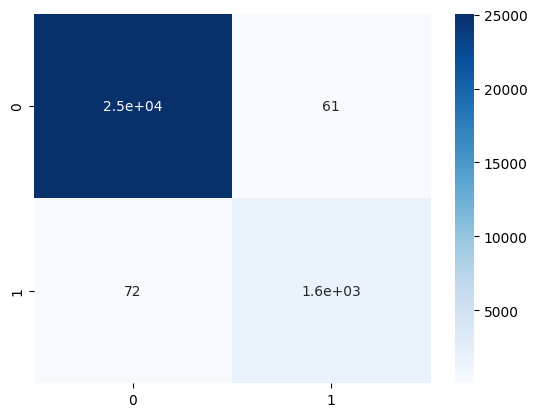

In [34]:
import seaborn as sns
y_pred = pipeline_baseline.predict_proba(X_test)[:,1]
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
target_names = ['class 0', 'class 1']
print(classification_report_imbalanced(y_test, y_pred_binary,  target_names=target_names))
conf_mat = confusion_matrix(y_test, y_pred_binary)
print(conf_mat)

sns.heatmap(conf_mat, annot=True, cmap='Blues')

                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.99      1.00      1.00      0.99    100573
    class 1       0.99      0.99      1.00      0.99      1.00      0.99      6787

avg / total       1.00      1.00      0.99      1.00      1.00      0.99    107360

[[100521     52]
 [    43   6744]]


<Axes: >

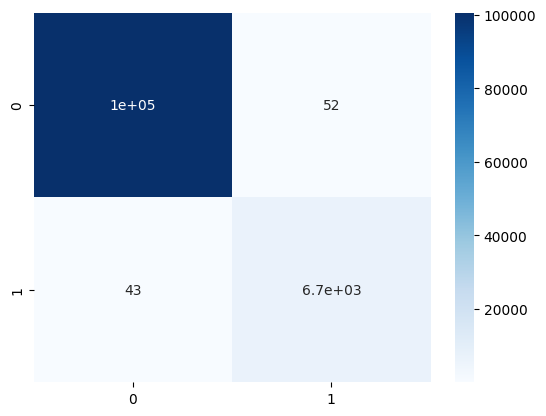

In [35]:
y_pred_train = pipeline_baseline.predict_proba(X_train)[:,1]
y_pred_binary_train = np.where(y_pred_train >= 0.5, 1, 0)
print(classification_report_imbalanced(y_train, y_pred_binary_train,  target_names=target_names))
conf_mat = confusion_matrix(y_train, y_pred_binary_train)
print(conf_mat)

sns.heatmap(conf_mat, annot=True, cmap='Blues')

In [12]:
confusion_matrix(y_train, y_pred_binary)

ValueError: Found input variables with inconsistent numbers of samples: [107360, 26841]

In [10]:
len(y_pred_binary_train)

26841

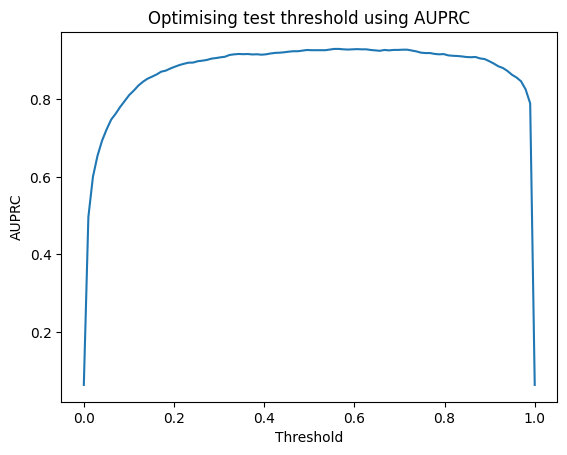

In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

thresholds_list = []
auprc_list = []
thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    y_pred_thres = [1 if e > threshold else 0 for e in y_pred]
    thresholds_list.append(threshold)
    #AUPRC
    auprc = average_precision_score(y_test, y_pred_thres)
    auprc_list.append(auprc)

threshold_df = pd.DataFrame({'thresholds': thresholds_list, 'auprc': auprc_list}).reset_index(drop=True)
plt.plot(threshold_df['thresholds'], threshold_df['auprc'])
plt.title("Optimising test threshold using AUPRC")
plt.xlabel("Threshold")
plt.ylabel("AUPRC")
plt.show()


In [162]:
threshold_df.sort_values(by='auprc', ascending=False)

,thresholds,auprc
56,0.565657,0.929472
55,0.555556,0.929468
60,0.606061,0.928961
62,0.626263,0.928422
61,0.616162,0.928414
...,...,...
3,0.030303,0.653941
2,0.020202,0.599988
1,0.010101,0.496617
0,0.000000,0.063709


In [170]:
threshold_df.loc[(threshold_df['auprc'] >=0.8)]

,thresholds,auprc
10,0.101010,0.811145
11,0.111111,0.822458
12,0.121212,0.835286
13,0.131313,0.845042
14,0.141414,0.852838
...,...,...
93,0.939394,0.872762
94,0.949495,0.862939
95,0.959596,0.855855
96,0.969697,0.846033
